# Overview

The goal of this project was to study the cardiotocography data set found at https://archive.ics.uci.edu/ml/datasets/cardiotocography, consisting of data from roughly 2100 fetal cardiotocograms and build a model to classify the fetal heart health as either normal, suspect, or pathological. The data were classified by obstetricians, using presumably a somewhat clear set of guidelines, but the purpose of this project is to determine whether these guidelines can be learned from the data alone (so was primarily for my own exploration and understanding). 

# Data Preparation

In [ ]:
import numpy as np
import pandas as pd

Saving CTG_rawdata.csv to CTG_rawdata.csv
User uploaded file "CTG_rawdata.csv" with length 213347 bytes


In [ ]:
## the following is code from the Google Colab documentation, to allow the raw data file to be uploaded:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
features = ["exam start time", "exam end time", "FHR baseline value - medical expert", "FHR baseline value", "accelerations / sec", "fetal movements / sec", "uterine contractions / sec", "percentage of time with abnormal short term variability", "mean value of short term variability", "percentage of time with abnormal long term variability", "mean value of long term variability", "light decelerations / sec", "severe decelerations / sec", "prolonged decelerations / sec", "repetitive decelerations / sec", "FHR histogram width", "FHR histogram min", "FHR histogram max", "number of FHR histogram peaks", "number of FHR histogram zeros", "FHR histogram mode", "FHR histogram mean", "FHR histogram median", "FHR histogram variance", "FHR histogram tendency", "A", "B", "C", "D", "E", "AD", "DE", "LD", "FS", "SUSP", "FHR pattern class code", "fetal state class code"]

CTG_rawdata = pd.read_csv('CTG_rawdata.csv', names=features, na_values = '?', dtype = 'float64', sep = ',')
CTG_rawdata = CTG_rawdata.drop(["A", "B", "C", "D", "E", "AD", "DE", "LD", "FS", "SUSP"], axis=1) ## the raw data set one-hot encoded one of the assessment columns, which I did not want -- I'll add it back in if necessary

In [ ]:
## splitting the data into a training set and test set
from sklearn.model_selection import train_test_split

train_raw, test_raw = train_test_split(CTG_rawdata, test_size = 0.2, random_state = 0)
train_raw.head()

,exam start time,exam end time,FHR baseline value - medical expert,FHR baseline value,accelerations / sec,fetal movements / sec,uterine contractions / sec,percentage of time with abnormal short term variability,mean value of short term variability,percentage of time with abnormal long term variability,...,FHR histogram max,number of FHR histogram peaks,number of FHR histogram zeros,FHR histogram mode,FHR histogram mean,FHR histogram median,FHR histogram variance,FHR histogram tendency,FHR pattern class code,fetal state class code
1719,1852.0,2950.0,131.0,131.0,10.0,0.0,4.0,54.0,1.5,0.0,...,169.0,6.0,0.0,151.0,141.0,144.0,22.0,1.0,2.0,1.0
1376,1284.0,1796.0,121.0,121.0,3.0,0.0,4.0,24.0,1.7,0.0,...,146.0,4.0,0.0,129.0,121.0,126.0,25.0,1.0,6.0,1.0
1454,1059.0,2137.0,148.0,148.0,4.0,0.0,5.0,40.0,0.9,8.0,...,173.0,5.0,0.0,157.0,156.0,158.0,3.0,0.0,2.0,1.0
1805,1875.0,2867.0,143.0,143.0,0.0,0.0,1.0,68.0,0.3,5.0,...,159.0,1.0,0.0,144.0,144.0,145.0,1.0,0.0,1.0,1.0
1969,1179.0,2072.0,138.0,138.0,6.0,0.0,4.0,59.0,0.7,0.0,...,168.0,1.0,0.0,148.0,145.0,147.0,6.0,0.0,2.0,1.0


In [ ]:
CTG_rawdata.isnull().sum()

exam start time                                            0
exam end time                                              0
FHR baseline value - medical expert                        0
FHR baseline value                                         0
accelerations / sec                                        0
fetal movements / sec                                      0
uterine contractions / sec                                 0
percentage of time with abnormal short term variability    0
mean value of short term variability                       0
percentage of time with abnormal long term variability     0
mean value of long term variability                        0
light decelerations / sec                                  0
severe decelerations / sec                                 0
prolonged decelerations / sec                              0
repetitive decelerations / sec                             0
FHR histogram width                                        0
FHR histogram min       

There are no missing values in the training or test set, which simplifies the task here considerably. We will begin with building a classifier to determine the fetal state class code from all features except the FHR pattern class code (so ignoring for the moment the FHR pattern class code data). For ease of data interpretation, we convert the numerical class codes assigned in both categories to their labels:

In [ ]:
train_raw["FHR pattern class code"] = train_raw["FHR pattern class code"].map({1: "calm sleep", 2: "REM sleep", 3: "calm vigilance", 4: "active vigilance", 5: "calm sleep or suspect pattern, with shifts", 6: "accelerative/decelerative pattern (stress situation)", 7: "decelerative pattern (vagal stimulation)", 8: "largely decelerative pattern", 9: "flat-sinusoidal shape (pathological state)", 10: "suspect pattern"})
train_raw["fetal state class code"] = train_raw["fetal state class code"].map({1: "Normal", 2: "Suspect", 3: "Pathological"})

test_raw["FHR pattern class code"] = test_raw["FHR pattern class code"].map({1: "calm sleep", 2: "REM sleep", 3: "calm vigilance", 4: "active vigilance", 5: "calm sleep or suspect pattern, with shifts", 6: "accelerative/decelerative pattern (stress situation)", 7: "decelerative pattern (vagal stimulation)", 8: "largely decelerative pattern", 9: "flat-sinusoidal shape (pathological state)", 10: "suspect pattern"})
test_raw["fetal state class code"] = test_raw["fetal state class code"].map({1: "Normal", 2: "Suspect", 3: "Pathological"})


The features will be studied more closely after the data has been prepared completely, but just to get a sense for now:

In [ ]:
train_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam start time,1700.0,881.675294,893.127800,0.0,62.0,538.0,1522.00,3296.0
exam end time,1700.0,1706.956471,928.353541,287.0,1014.0,1285.0,2437.25,3599.0
FHR baseline value - medical expert,1700.0,133.318235,9.738271,106.0,126.0,133.0,140.00,159.0
FHR baseline value,1700.0,133.318235,9.738271,106.0,126.0,133.0,140.00,159.0
accelerations / sec,1700.0,2.727647,3.588854,0.0,0.0,1.0,4.00,26.0
fetal movements / sec,1700.0,6.801176,35.270441,0.0,0.0,0.0,2.00,564.0
uterine contractions / sec,1700.0,3.649412,2.864720,0.0,1.0,3.0,5.00,23.0
percentage of time with abnormal short term variability,1700.0,47.045294,17.138592,12.0,32.0,49.0,61.00,86.0
mean value of short term variability,1700.0,1.322000,0.864586,0.2,0.7,1.2,1.70,6.3
percentage of time with abnormal long term variability,1700.0,9.802941,18.404247,0.0,0.0,0.0,11.00,91.0


It appears that: (a) baseline values in heart rate read by the medical expert do not actually differ from those given by the "SisPorto" system (perhaps it was just a mistake in labeling and managing the data) and (b) the "repetitive decelerations / sec" is uniformly zero. We therefore remove these two columns from both train_raw and test_raw.

In [ ]:
train = train_raw.drop(columns=["FHR baseline value - medical expert", "repetitive decelerations / sec"])
test = test_raw.drop(columns=["FHR baseline value - medical expert", "repetitive decelerations / sec"])
train.shape

(1700, 25)

In [ ]:
train["fetal state class code"].value_counts()

Normal          1329
Suspect          237
Pathological     134
Name: fetal state class code, dtype: int64

In [ ]:
##in case i want to relabel the tendency feature
#train_raw["FHR histogram tendency"] = train_raw["FHR histogram tendency"].map({-1: "skewed left", 0: "symmetric", 1: "skewed right"})
#test_raw["FHR histogram tendency"] = test_raw["FHR histogram tendency"].map({-1: "skewed left", 0: "symmetric", 1: "skewed right"})
#train_raw.head().transpose()

In [ ]:
## I doubt that the exam duration will actually make a meaningful difference here, but just for now:
train["exam duration"] = train["exam end time"] - train["exam start time"]
test["exam duration"] = test["exam end time"] - test["exam start time"]

In [ ]:
train = train.drop(columns=["exam start time", "exam end time"])
test = test.drop(columns=["exam start time", "exam end time"])

In [ ]:
train.shape

(1700, 24)

1. for use in the actual model, we'll scale (X - mean(X))/std(X)
2. the only categorical feature is the tendency one, which we will have to look at later -- we'll get a better sense of what is really going on there, and then make the decision

In [ ]:
train.head().transpose()

,1719,1376,1454,1805,1969
FHR baseline value,131.0,121.0,148.0,143.0,138.0
accelerations / sec,10.0,3.0,4.0,0.0,6.0
fetal movements / sec,0.0,0.0,0.0,0.0,0.0
uterine contractions / sec,4.0,4.0,5.0,1.0,4.0
percentage of time with abnormal short term variability,54.0,24.0,40.0,68.0,59.0
mean value of short term variability,1.5,1.7,0.9,0.3,0.7
percentage of time with abnormal long term variability,0.0,0.0,8.0,5.0,0.0
mean value of long term variability,4.0,4.1,11.8,9.4,8.5
light decelerations / sec,1.0,2.0,0.0,0.0,0.0
severe decelerations / sec,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_scaled = train.copy()
test_scaled = test.copy()

to_not_scale = {"FHR pattern class code", "fetal state class code", "FHR histogram tendency", "repetitive decelerations / sec", "exam start time", "exam end time"}
features_to_scale = [k for k in list(train_scaled.columns) if k not in to_not_scale]

features_to_scale

['FHR baseline value',
 'accelerations / sec',
 'fetal movements / sec',
 'uterine contractions / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'severe decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram min',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram mode',
 'FHR histogram mean',
 'FHR histogram median',
 'FHR histogram variance',
 'exam duration']

In [ ]:
for feature in features_to_scale:
  mean = train_scaled[feature].mean()
  std = train_scaled[feature].std()
  train_scaled[feature] = (train_scaled[feature] - mean)/std
  test_scaled[feature] = (test_scaled[feature] - mean)/std

In [ ]:
train_scaled.head().transpose()

,1719,1376,1454,1805,1969
FHR baseline value,-0.238054,-1.26493,1.507636,0.994197,0.480759
accelerations / sec,2.026372,0.075889,0.354529,-0.760033,0.91181
fetal movements / sec,-0.192829,-0.192829,-0.192829,-0.192829,-0.192829
uterine contractions / sec,0.122381,0.122381,0.471456,-0.924841,0.122381
percentage of time with abnormal short term variability,0.405792,-1.344643,-0.411078,1.222662,0.697531
mean value of short term variability,0.205879,0.437204,-0.488095,-1.182069,-0.71942
percentage of time with abnormal long term variability,-0.532646,-0.532646,-0.097963,-0.260969,-0.532646
mean value of long term variability,-0.74473,-0.727193,0.623129,0.202249,0.044419
light decelerations / sec,-0.225168,0.173983,-0.624318,-0.624318,-0.624318
severe decelerations / sec,-0.054297,-0.054297,-0.054297,-0.054297,-0.054297


# Exploratory Data Analysis and Feature Selection

We now take a look at some of the plots of the different features and correlations. Note that all of the features, except that describing the tendency of the FHR histogram, are continuous.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

We first look at the heat map, to get a rough, initial sense for correlations between the features. Currently, the fetal state class code is one of "normal", "suspect", and "pathological": since these labels increase in severity, to get a rough sense for how the features affect the class code, we will also include the fetal state class code, with the labels converted to 0, 1, and 2 respectively.

In [ ]:
train_numericalstates = train.copy()
train_numericalstates["fetal state class code"].map({"Normal": 1, "Suspect": 2, "Pathological": 3})

1719    1
1376    1
1454    1
1805    1
1969    1
       ..
1033    1
1731    1
763     1
835     1
1653    1
Name: fetal state class code, Length: 1700, dtype: int64

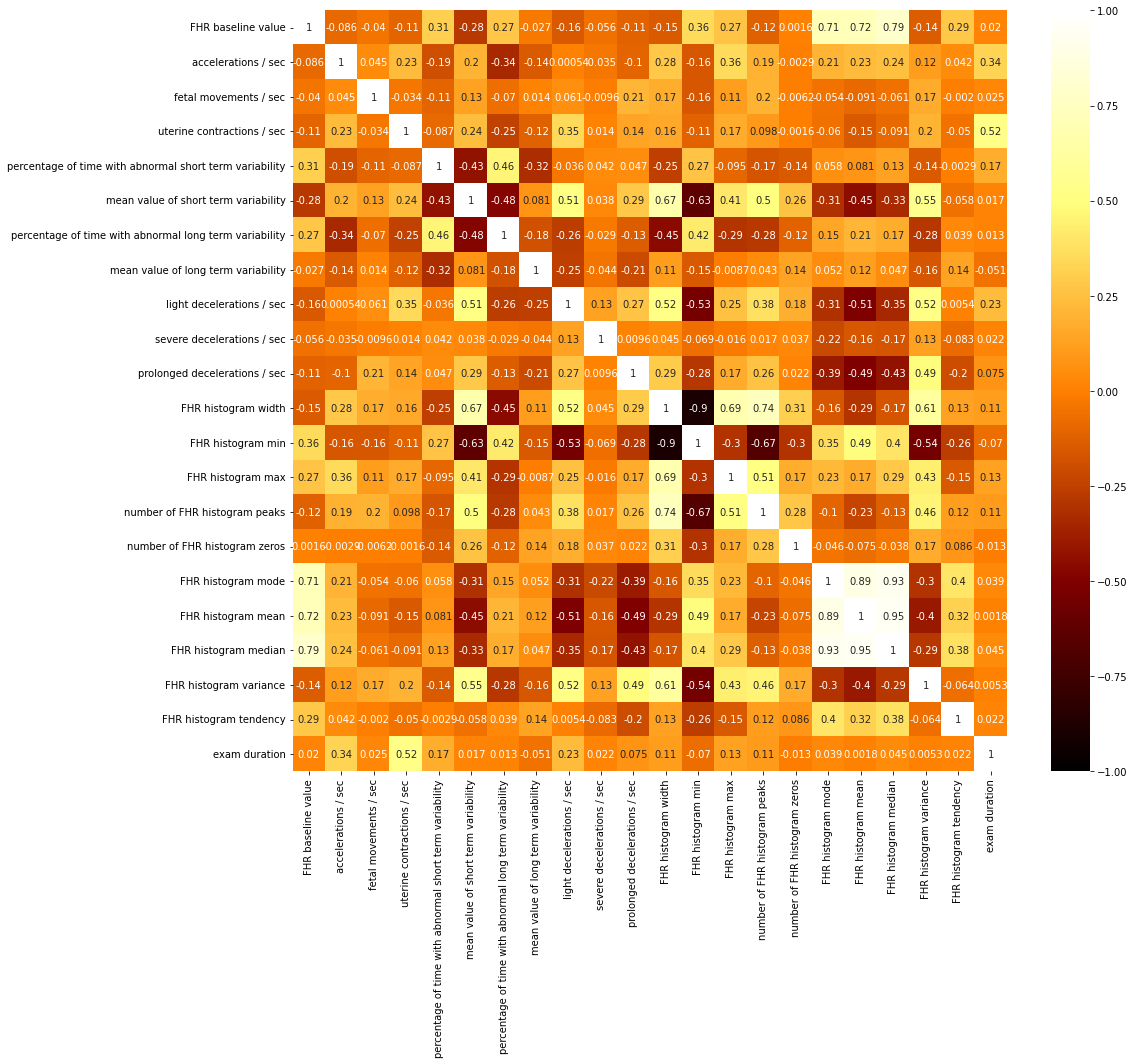

In [ ]:
## heat map

plt.figure(figsize=(16, 14))
hm = sns.heatmap(train_numericalstates.corr(), vmin=-1, vmax=1, annot=True, cmap='afmhot')

Observations about the correlations:
- uterine contractions / sec, the features about long and short term variability, as well as the accelerations and decelerations all seem to be related.
- the histogram statistics are obviously all correlated; it would be good to see how best to trim this down, including deciding how to handle the information about the tendency
- the FHR baseline value of course seems related to practically all the other variables (not sure how exactly it is computed from the FHR graph)
- the features that seem most connected to the fetal state class code, at least as far as the linear correlation can detect, are: accelerations / sec, percentage of time with long/short term variability, prolonged decelerations, FHR mean/median/mode

(There were few enough features that I could do this by hand, in this case. If there were more, I probably would want to use PCA to simplify the problem; it would be interesting to experiment with it here as well, once the final features have been selected.)

We now look at some plots, to continue to get a sense for the indicative features. Features we will definitely drop beforehand, though, are: fetal movements / sec, severe decelerations / sec, and exam duration.

In [ ]:
plot_features = list(train.columns)
to_not_plot = {"fetal movements / sec", "severe decelerations / sec", "exam duration", "FHR pattern class code", "fetal state class code"}
plot_features = [x for x in plot_features if x not in to_not_plot]
len(plot_features)

19

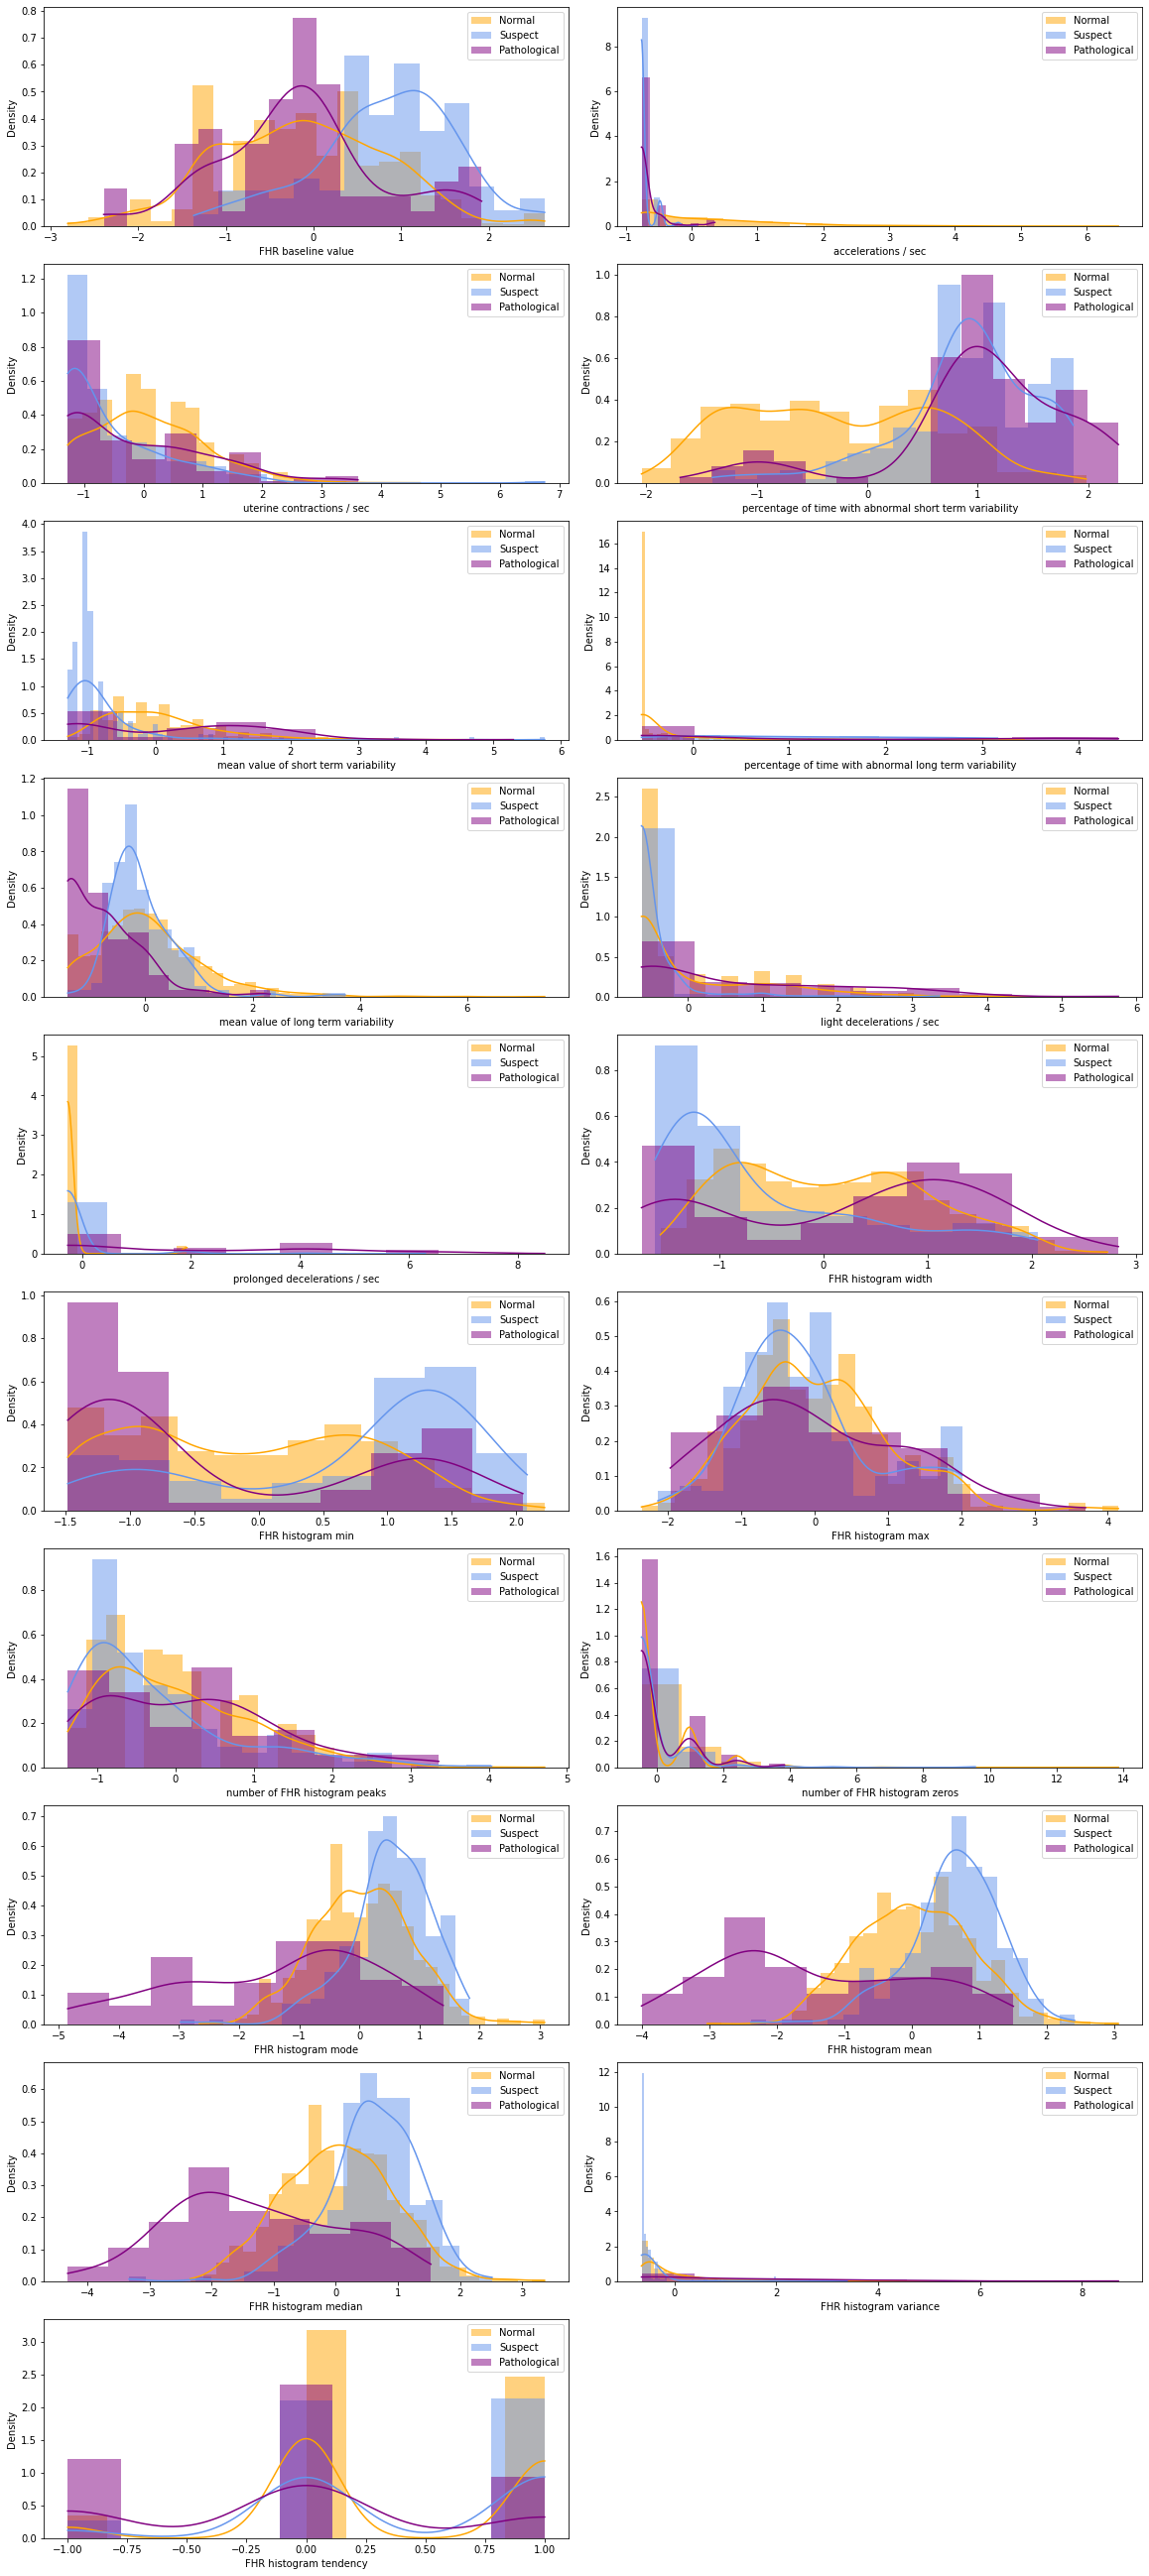

In [ ]:
fig = plt.figure(figsize=(16,36))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for k, kcolumn in enumerate(plot_features, 1):
    ax = fig.add_subplot(10, 2, k)
    sns.histplot(train_scaled.loc[train_scaled["fetal state class code"] == "Normal", f"{kcolumn}"], color="orange", label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(train_scaled.loc[train_scaled["fetal state class code"] == "Suspect", f"{kcolumn}"], color="cornflowerblue", label="Suspect",kde=True, stat="density", linewidth=0)
    sns.histplot(train_scaled.loc[train_scaled["fetal state class code"] == "Pathological", f"{kcolumn}"], color="purple", label="Pathological",kde=True, stat="density", linewidth=0)
    ax.legend()

plt.tight_layout(pad=0.4)
plt.show()

Observations about the FHR histogram statistics:
- the FHR histogram mean/median/mode plots suggest that if the FHRs are on the lower side, there is more likely to be a "pathological" diagnosis, and if they are on the higher side, there is more likely to be a "suspect" diagnosis. Not quite linear. (Maybe changing the numerical labels to 2, 3, and 1 respectively would give a better idea of what is going on here, as far as the histogram's connection goes.)
- FHR histogram tendency does seem to have a relationship here, but the same 'phenomenon' is revealed by the FHR histogram mean/median/mode. The same is true about the FHR baseline value.
- Interestingly, the FHR histogram variance being very low seems to suggest a "suspect" diagnosis and it being very high seems to suggest a "pathological" diagnosis. It is similar with the FHR histogram width.
- Perhaps doing a $x \mapsto x^2$ transformation would be helpful in getting a normal vs suspect/pathological linear separation. The suspect vs. pathological separation is less difficult to do (i.e. even a simple x > 0 vs x < 0 would be fairly accurate, it seems).

Question: is the idea here that if the heart rate is very high, and doesn't change much, it is a problem, but a more severe issue if the rates get very low and vary significantly? And for it to be normal, you want the FHRs to be around a certain number and vary just slightly? (Imprecise, here.)
- We will drop the FHR baseline rate going forward.

In [ ]:
model_features = plot_features
model_features.remove("FHR baseline value")
len(model_features)

18

Observations about the accelerations, decelerations, and long/short term variability:
- Uterine contractions seem to allow us to differentiate between normal and suspect/pathological, but this 'phenomenon' is also revealed by the percentage of time with short term variability. We will drop this feature going forward.
- The accelerations, decelerations, percentage of time with long/short term variability, and their respective means all seem to give some useful information: of these, the only feature which does not work in a "linear" way is the mean of the short term variability. It might be interesting to consider a $x \mapsto x^2$ transformation here as well. But in general, it seems worth keeping all of these features.

The bulk of the 'savings' can come from the FHR histogram data being consolidated.

In [ ]:
model_features.remove("uterine contractions / sec")
len(model_features)

17

In [ ]:
model_features
len(model_features)

17

We now address the FHR histogram statistics, and decide which features to select. For ease of visualization, we review the correlation heat map on these features alone: 'FHR histogram width', 'FHR histogram min', 'FHR histogram max', 'number of FHR histogram peaks', 'number of FHR histogram zeros', 'FHR histogram mode', 'FHR histogram mean', 'FHR histogram median', 'FHR histogram variance', 'FHR histogram tendency'.

In [ ]:
FHR_histogram_features = ['FHR histogram width', 'FHR histogram min', 'FHR histogram max', 'number of FHR histogram peaks', 'number of FHR histogram zeros', 'FHR histogram mode', 'FHR histogram mean', 'FHR histogram median', 'FHR histogram variance', 'FHR histogram tendency']

In [ ]:
train_FHRhistogram = train_numericalstates.copy()
not_FHR = list(train_FHRhistogram.columns)
not_FHR = [x for x in not_FHR if x not in FHR_histogram_features]
not_FHR

['FHR baseline value',
 'accelerations / sec',
 'fetal movements / sec',
 'uterine contractions / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'severe decelerations / sec',
 'prolonged decelerations / sec',
 'FHR pattern class code',
 'fetal state class code',
 'exam duration']

In [ ]:
train_FHRhistogram = train_FHRhistogram.drop(columns=not_FHR)
train_FHRhistogram.head().transpose()

,1719,1376,1454,1805,1969
FHR histogram width,85.0,72.0,47.0,26.0,43.0
FHR histogram min,84.0,74.0,126.0,133.0,125.0
FHR histogram max,169.0,146.0,173.0,159.0,168.0
number of FHR histogram peaks,6.0,4.0,5.0,1.0,1.0
number of FHR histogram zeros,0.0,0.0,0.0,0.0,0.0
FHR histogram mode,151.0,129.0,157.0,144.0,148.0
FHR histogram mean,141.0,121.0,156.0,144.0,145.0
FHR histogram median,144.0,126.0,158.0,145.0,147.0
FHR histogram variance,22.0,25.0,3.0,1.0,6.0
FHR histogram tendency,1.0,1.0,0.0,0.0,0.0


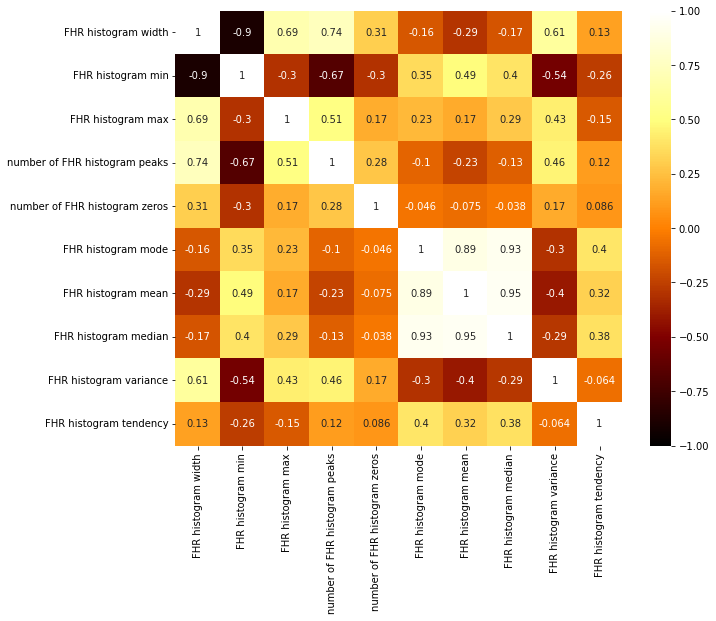

In [ ]:
plt.figure(figsize=(10, 8))
hm_FHR = sns.heatmap(train_FHRhistogram.corr(), vmin=-1, vmax=1, annot=True, cmap='afmhot')

FHR histogram statistic analysis: The distribution of the FHR histogram tendency values indicates that most of the sample histograms are skewed, specifically to the right. Hence of the mean, median, and modes, we will keep only the median. (Note also its high correlation with the other two.) To measure the spread, we will keep the histogram width, instead of the variance and will also keep the max; this information combined also gives us equivalent information about the spread. We will keep the number of peaks and zeros, though I am not sure how much information they will add.

In [ ]:
model_features.remove("FHR histogram mean")
model_features.remove("FHR histogram mode")
model_features.remove("FHR histogram variance")
model_features.remove("FHR histogram min")
model_features.remove("FHR histogram tendency")

In [ ]:
print(model_features)

['accelerations / sec', 'percentage of time with abnormal short term variability', 'mean value of short term variability', 'percentage of time with abnormal long term variability', 'mean value of long term variability', 'light decelerations / sec', 'prolonged decelerations / sec', 'FHR histogram width', 'FHR histogram max', 'number of FHR histogram peaks', 'number of FHR histogram zeros', 'FHR histogram median']


Finally, the model features we will experiment with the $x \mapsto x^2$ transformation are:
- mean value of short term variability
- FHR histogram width
- FHR histogram median

In [ ]:
train_scaled_squares = train_scaled.copy()
train_scaled_squares["(mean value of short term variability)^2"] = train_scaled_squares["mean value of short term variability"].map(lambda x: x*x)
train_scaled_squares["(FHR histogram width)^2"] = train_scaled_squares["FHR histogram width"].map(lambda x: x*x)
train_scaled_squares["(FHR histogram median)^2"] = train_scaled_squares["FHR histogram median"].map(lambda x: x*x)

test_scaled_squares = test_scaled.copy()
test_scaled_squares["(mean value of short term variability)^2"] = test_scaled_squares["mean value of short term variability"].map(lambda x: x*x)
test_scaled_squares["(FHR histogram width)^2"] = test_scaled_squares["FHR histogram width"].map(lambda x: x*x)
test_scaled_squares["(FHR histogram median)^2"] = test_scaled_squares["FHR histogram median"].map(lambda x: x*x)

train_scaled_squares.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FHR baseline value,1700.0,5.365643e-16,1.000000,-2.805245,-0.751492,-0.032679,0.686135,2.637200
accelerations / sec,1700.0,6.269495e-17,1.000000,-0.760033,-0.760033,-0.481392,0.354529,6.484620
fetal movements / sec,1700.0,4.179663e-18,1.000000,-0.192829,-0.192829,-0.192829,-0.136125,15.797898
uterine contractions / sec,1700.0,0.000000e+00,1.000000,-1.273916,-0.924841,-0.226693,0.471456,6.754792
percentage of time with abnormal short term variability,1700.0,-8.568309e-17,1.000000,-2.044818,-0.877861,0.114053,0.814227,2.272923
mean value of short term variability,1700.0,-4.388646e-17,1.000000,-1.297731,-0.719420,-0.141108,0.437204,5.757670
percentage of time with abnormal long term variability,1700.0,0.000000e+00,1.000000,-0.532646,-0.532646,-0.532646,0.065043,4.411865
mean value of long term variability,1700.0,-3.448222e-17,1.000000,-1.446196,-0.639510,-0.148484,0.465299,7.444884
light decelerations / sec,1700.0,-1.880848e-17,1.000000,-0.624318,-0.624318,-0.624318,0.573133,5.762086
severe decelerations / sec,1700.0,-8.359326e-18,1.000000,-0.054297,-0.054297,-0.054297,-0.054297,18.406537


In [ ]:
train_red_features = train_scaled.copy()
drop_final = [x for x in list(train_red_features.columns) if x not in model_features]
drop_final
train_red_features = train_red_features.drop(columns=drop_final)
list(train_red_features.columns)

['accelerations / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram median']

In [ ]:
test_red_features = test_scaled.copy()
test_red_features = test_red_features.drop(columns=drop_final)
list(test_red_features.columns)

['accelerations / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram median']

In [ ]:
train_red_squares_features = train_scaled_squares.copy()
train_red_squares_features = train_red_squares_features.drop(columns=drop_final)
list(train_red_squares_features.columns)

['accelerations / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram median',
 '(mean value of short term variability)^2',
 '(FHR histogram width)^2',
 '(FHR histogram median)^2']

In [ ]:
test_red_squares_features = test_scaled_squares.copy()
test_red_squares_features = test_red_squares_features.drop(columns=drop_final)
list(test_red_squares_features.columns)

['accelerations / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram median',
 '(mean value of short term variability)^2',
 '(FHR histogram width)^2',
 '(FHR histogram median)^2']

For the sake of curiosity, we will find the principal components (roughly the first 10-12) of the scaled training data:

In [ ]:
train_scaled_features = train_scaled.drop(columns=["FHR pattern class code", "fetal state class code"])
list(train_scaled_features.columns)

['FHR baseline value',
 'accelerations / sec',
 'fetal movements / sec',
 'uterine contractions / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'severe decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram min',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram mode',
 'FHR histogram mean',
 'FHR histogram median',
 'FHR histogram variance',
 'FHR histogram tendency',
 'exam duration']

**PENDING: PCA**

# Model Selection


In [ ]:
train_labels = train["fetal state class code"]
test_labels = test["fetal state class code"]

## the feature vectors
train_red_features, train_red_squares_features

(      accelerations / sec  \
 1719             2.026372   
 1376             0.075889   
 1454             0.354529   
 1805            -0.760033   
 1969             0.911810   
 ...                   ...   
 1033             0.075889   
 1731             1.747732   
 763              0.075889   
 835              0.075889   
 1653            -0.760033   
 
       percentage of time with abnormal short term variability  \
 1719                                           0.405792         
 1376                                          -1.344643         
 1454                                          -0.411078         
 1805                                           1.222662         
 1969                                           0.697531         
 ...                                                 ...         
 1033                                          -1.286296         
 1731                                           0.814227         
 763                                        

In [ ]:
## so the final labels are numerical
train_labels = train_labels.map({"Normal": 0, "Suspect": 1, "Pathological": 2})
test_labels = test_labels.map({"Normal": 0, "Suspect": 1, "Pathological": 2})
train_labels

1719    0
1376    0
1454    0
1805    0
1969    0
       ..
1033    0
1731    0
763     0
835     0
1653    0
Name: fetal state class code, Length: 1700, dtype: int64

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
## adding a column of 1s to the training data:
train_red_features["ones"] = [1]*len(train_red_features.index)
train_red_features.head().transpose()

,1719,1376,1454,1805,1969
accelerations / sec,2.026372,0.075889,0.354529,-0.760033,0.911810
percentage of time with abnormal short term variability,0.405792,-1.344643,-0.411078,1.222662,0.697531
mean value of short term variability,0.205879,0.437204,-0.488095,-1.182069,-0.719420
percentage of time with abnormal long term variability,-0.532646,-0.532646,-0.097963,-0.260969,-0.532646
mean value of long term variability,-0.744730,-0.727193,0.623129,0.202249,0.044419
light decelerations / sec,-0.225168,0.173983,-0.624318,-0.624318,-0.624318
prolonged decelerations / sec,-0.261323,-0.261323,-0.261323,-0.261323,-0.261323
FHR histogram width,0.375693,0.039370,-0.607407,-1.150699,-0.710891
FHR histogram max,0.273459,-1.017251,0.497930,-0.287719,0.217341
number of FHR histogram peaks,0.654850,-0.021689,0.316580,-1.036497,-1.036497


In [ ]:
train_red_features[:1]

,accelerations / sec,percentage of time with abnormal short term variability,mean value of short term variability,percentage of time with abnormal long term variability,mean value of long term variability,light decelerations / sec,prolonged decelerations / sec,FHR histogram width,FHR histogram max,number of FHR histogram peaks,number of FHR histogram zeros,FHR histogram median,ones
1719,2.026372,0.405792,0.205879,-0.532646,-0.74473,-0.225168,-0.261323,0.375693,0.273459,0.65485,-0.459894,0.402598,1


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose = 1, random_state = 1)
z = tsne.fit_transform(train_red_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1700 samples in 0.006s...
[t-SNE] Computed neighbors for 1700 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1700
[t-SNE] Computed conditional probabilities for sample 1700 / 1700
[t-SNE] Mean sigma: 0.842416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.723221
[t-SNE] KL divergence after 1000 iterations: 1.005981


In [ ]:
tsne_features = pd.DataFrame()
tsne_features["labels"] = train_labels
tsne_features["comp1"] = z[:, 0]
tsne_features["comp2"] = z[:, 1]

sns.scatterplot(x = "comp1", y="comp2", hue=tsne_features.labels.tolist(), palette=sns.color_palette("hls", 3), data=tsne_features).set(title="CTG Data t-SNE Projection")

1719   -16.033960
1376    -3.712225
1454     8.947064
1805    35.120819
1969     7.429769
          ...    
1033    -4.879926
1731   -36.917007
763    -15.333688
835    -30.164179
1653    33.412960
Name: comp1, Length: 1700, dtype: float32

Interestingly, it appears that just looking at the first component, and considering the rough brackets Pathological: $(-\infty, -55]$, Normal: $(-50, 30)$, Suspect: $[30, \infty)$ is reasonable!

In [ ]:
## with squared features, just out of curiosity:

tsne_squares = TSNE(n_components=2, verbose = 1, random_state = 1)
z_squares = tsne_squares.fit_transform(train_red_squares_features)

tsne_features_squares = pd.DataFrame()
tsne_features_squares["labels"] = train_labels
tsne_features_squares["comp1"] = z_squares[:, 0]
tsne_features_squares["comp2"] = z_squares[:, 1]

sns.scatterplot(x = "comp1", y="comp2", hue=tsne_features_squares.labels.tolist(), palette=sns.color_palette("hls", 3), data=tsne_features_squares).set(title="CTG Data (with Squared Features) t-SNE Projection")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1700 samples in 0.012s...
[t-SNE] Computed neighbors for 1700 samples in 0.325s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1700
[t-SNE] Computed conditional probabilities for sample 1700 / 1700
[t-SNE] Mean sigma: 0.970020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.445412
[t-SNE] KL divergence after 1000 iterations: 0.972091


**Multinomial Logistic Regression**

We will begin with a multinomial logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression
multilog = LogisticRegression(random_state = 0)
multilog.fit(train_red_features, train_labels)
labels_pred_ml = multilog.predict(train_red_features)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print(confusion_matrix(train_labels, labels_pred_ml))

[[1258   51   20]
 [  78  151    8]
 [  13   24   97]]


In [ ]:
cross_val_score(multilog, train_red_features, train_labels, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.87647059, 0.89117647, 0.89411765, 0.86470588, 0.87647059])

In [ ]:
probs_200 = 100*pd.DataFrame(multilog.predict_proba(train_red_features[0:200]))
probs_200["actual labels"] = np.array(train_labels[0:200])
probs_200["predicted labels"] = np.array(labels_pred_ml[0:200])
print(probs_200)

             0          1          2  actual labels  predicted labels
0    99.999355   0.000632   0.000013              0                 0
1    99.981090   0.018232   0.000677              0                 0
2    99.187067   0.811915   0.001018              0                 0
3    43.746780  55.026171   1.227049              0                 1
4    99.890272   0.107651   0.002078              0                 0
..         ...        ...        ...            ...               ...
195  99.989119   0.010146   0.000735              0                 0
196  99.977249   0.021933   0.000818              0                 0
197  99.265643   0.593382   0.140975              0                 0
198  99.929456   0.069180   0.001364              0                 0
199   0.002291   0.062272  99.935437              2                 2

[200 rows x 5 columns]


Somewhat surprisingly, this model is quite reasonable!

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomforest_100_50_10 = RandomForestClassifier(n_estimators=100, min_samples_split = 100, max_leaf_nodes=10, n_jobs=-1)
randomforest_100_50_10.fit(train_red_features, train_labels)
labels_pred_rf_100_50_10 = randomforest_100_50_10.predict(train_red_features)

In [ ]:
print(confusion_matrix(train_labels, labels_pred_rf_100_50_10))

[[1312   13    4]
 [  81  153    3]
 [  23   21   90]]


In [ ]:
accuracy_score(train_labels, labels_pred_rf_100_50_10)

0.9147058823529411

In [ ]:
cross_val_score(randomforest_100_50_10, train_red_features, train_labels, cv=5)

array([0.90294118, 0.90588235, 0.89411765, 0.91176471, 0.88235294])

In [ ]:
list(train_red_features.columns)

['accelerations / sec',
 'percentage of time with abnormal short term variability',
 'mean value of short term variability',
 'percentage of time with abnormal long term variability',
 'mean value of long term variability',
 'light decelerations / sec',
 'prolonged decelerations / sec',
 'FHR histogram width',
 'FHR histogram max',
 'number of FHR histogram peaks',
 'number of FHR histogram zeros',
 'FHR histogram median',
 'ones']

In [ ]:
## feature importance -- interesting to look at
for name, score in zip(list(train_red_features.columns), randomforest_100_50_10.feature_importances_):
  print(name, score)

accelerations / sec 0.09687062564913268
percentage of time with abnormal short term variability 0.1975381472485517
mean value of short term variability 0.2007506677797421
percentage of time with abnormal long term variability 0.17575752468454492
mean value of long term variability 0.054181800885381486
light decelerations / sec 0.012594416175764164
prolonged decelerations / sec 0.09319276044894924
FHR histogram width 0.03457136157138784
FHR histogram max 0.014233469606347493
number of FHR histogram peaks 0.0058256577964765225
number of FHR histogram zeros 0.0009268275353430185
FHR histogram median 0.11355674061837887
ones 0.0


This might be a useful way to do feature selection in the future.

Hyperparameter Tuning with GridSearch: 

In [ ]:
from sklearn.model_selection import GridSearchCV

randomforest = RandomForestClassifier()

forest_parameters = {'n_estimators': [100, 150, 200, 250],
                     'min_samples_split': [50, 75, 100, 150],
                     'max_leaf_nodes': [5, 10, 12, 15, 20]}

In [ ]:
search = GridSearchCV(randomforest, forest_parameters, scoring='accuracy', verbose=3)

In [ ]:
search.fit(train_red_features, train_labels)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=100;, score=0.897 total time=   0.5s
[CV 2/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=100;, score=0.891 total time=   0.4s
[CV 3/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=100;, score=0.894 total time=   0.4s
[CV 4/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=100;, score=0.882 total time=   0.6s
[CV 5/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=100;, score=0.865 total time=   0.6s
[CV 1/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=150;, score=0.900 total time=   0.8s
[CV 2/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=150;, score=0.882 total time=   0.8s
[CV 3/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=150;, score=0.888 total time=   0.9s
[CV 4/5] END max_leaf_nodes=5, min_samples_split=50, n_estimators=150;, score=0.879 total time=   0.8s
[CV 5/5] EN

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_leaf_nodes': [5, 10, 12, 15, 20],
                         'min_samples_split': [50, 75, 100, 150],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=3)

**PENDING:** Eventually would like to look at the other multiclass scores, to take into account the false positives...

**SVM**

We next build support vector classifiers, using the data used in the previous two models as well as the squared data (to see whether this aids in separability, ultimately).

# Risk Score Experiments

Question: is there a way we can come up with a sort of risk score, and then decide thresholds ourselves to determine a "normal", "suspect", or "pathological" state?

Our goals here are to (a) experiment with some neural network models and (b) figure out how best to implement a risk score. The output of our model will be a risk score from 0 to 1 -- the idea is that if it's very close to 1, we should be classifying them as "pathological", close to 0 "normal", and for some undetermined bracket in between, "suspect". Looking at the probabilities in the multinomial logistic regression section, it is clear that simply considering the probability of the label "normal" is insufficient — often very low values corresponded to "suspect" and mid-range values to "pathological".

Idea 1: Try a binary classifier, healthy vs. not, and see how useful the probability is to us. I don't expect it to really help us differentiate between the suspect and pathological cases, though.

Idea 2: Try a regression, perhaps with the scaled target variables Normal = 0, Suspect = 1/2, Pathological = 1 and mean squared error loss function.

The latter seems the more promising of the two (and would also give us a different view of the problem than multinomial logistic regression), so we experiment with this first.

In [ ]:
## note: sklearn.preprocessing's StandardScaler does the (x - mean)/std rescaling

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train_labels_regression = (1/2)*train_labels
len(list(train_red_features.columns))

13

In [ ]:
regression_1 = keras.models.Sequential() ## starting here with the sequential api; still need to familiarize more with other options, but the subject is so vast
regression_1.add(keras.layers.Dense(units=1))
input_shape = (None, 13)
regression_1.build(input_shape) 
## if the data hadn't already been preprocessed, would have wanted to include the normalization layer first
regression_1.summary()
regression_1.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')
history_1 = regression_1.fit(train_red_features, train_labels_regression, epochs=1000, validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
43/43 [==============================] - 1s 5ms/step - loss: 0.2795 - val_loss: 0.0550
Epoch 2/1000
43/43 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0687
Epoch 3/1000
43/43 [==============================] - 0s 3ms/step - loss: 0.0553 - val_loss: 0.0482
Epoch 4/1000
43/43 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0502
Epoch 5/1000
43/43 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0453
Epoch 6/1000
43/43 [==============================] - 0s 2ms/step - loss: 0.0473 - va

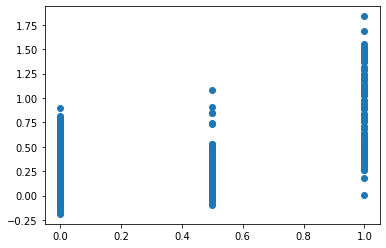

In [ ]:
linreg_predict = regression_1.predict(train_red_features)
plt.scatter(train_labels_regression, linreg_predict)

The MSE appeared low, but the plot reveals it actually wasn't very good at all... It would be impossible to extract any meaningful information from this. I want to experiment with a more suitable loss function. Perhaps if we go back to 0, 1, 2, and then take roughly $\ell^2$ loss within 0.5, and roughly $\ell^1$ above:

In [ ]:
huber = tf.keras.losses.Huber(delta=0.3) ## explain more about what this is doing
y_true = [[0, 1], [0, 0]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]
huber(y_true, y_pred).numpy()

0.120000005

In [ ]:
regression_1_huber = keras.models.Sequential() ## starting here with the sequential api; still need to familiarize more with other options, but the subject is so vast
regression_1_huber.add(keras.layers.Dense(units=1))
input_shape = (None, 13)
regression_1_huber.build(input_shape) 
## if the data hadn't already been preprocessed, would have wanted to include the normalization layer first
regression_1_huber.summary()
regression_1_huber.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss=huber)
history_1_huber = regression_1.fit(train_red_features, train_labels, epochs=500, validation_split=0.2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1842 - val_loss: 0.1820
Epoch 2/500
43/43 [==============================] - 0s 6ms/step - loss: 0.1981 - val_loss: 0.1715
Epoch 3/500
43/43 [==============================] - 0s 5ms/step - loss: 0.2174 - val_loss: 0.3054
Epoch 4/500
43/43 [==============================] - 0s 7ms/step - loss: 0.1940 - val_loss: 0.1851
Epoch 5/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1931 - val_loss: 0.1840
Epoch 6/500
43/43 [==============================] - 0s 5ms/step - loss: 0.1743 - val_loss

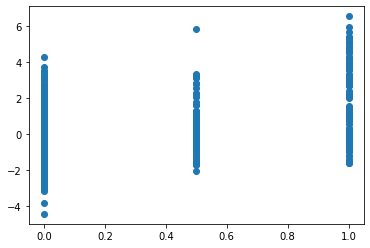

In [ ]:
linreg_huber_predict = regression_1_huber.predict(train_red_features)
plt.scatter(train_labels_regression, linreg_huber_predict)

Linear models unsurprisingly haven't gotten us close to getting something useful, so will now try to add some hidden layers to see if it might be improved.

In [ ]:
regression_2_huber = keras.models.Sequential() ## starting here with the sequential api; still need to familiarize more with other options, but the subject is so vast
regression_2_huber.add(keras.layers.Dense(500, activation="relu"))
regression_2_huber.add(keras.layers.Dense(1))
input_shape = (None, 13)
regression_2_huber.build(input_shape) 
## if the data hadn't already been preprocessed, would have wanted to include the normalization layer first
regression_2_huber.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 500)               7000      
                                                                 
 dense_29 (Dense)            (None, 1)                 501       
                                                                 
Total params: 7,501
Trainable params: 7,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
regression_2_huber.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss=huber)
history_2_huber = regression_2_huber.fit(train_red_features, train_labels, epochs=200, validation_split=0.2)

Epoch 1/200
43/43 [==============================] - 1s 6ms/step - loss: 0.3571 - val_loss: 0.0676
Epoch 2/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0741
Epoch 3/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0454
Epoch 4/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0419
Epoch 5/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0433 - val_loss: 0.0587
Epoch 6/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.0531
Epoch 7/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0566
Epoch 8/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0377 - val_loss: 0.0468
Epoch 9/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0680
Epoch 10/200
43/43 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0558
Epoch 11/

array([[ 0.01855562],
       [ 0.01855562],
       [ 0.01855562],
       ...,
       [-0.13148387],
       [ 0.01855562],
       [ 0.20786564]], dtype=float32)

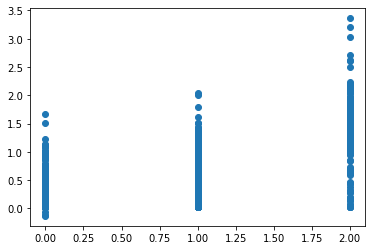

In [ ]:
reg2_huber_predict = regression_2_huber.predict(train_red_features)
plt.scatter(train_labels, reg2_huber_predict)
reg2_huber_predict

Note that here, adding a second hidden layer results in a model that was predicting the same number for every training data point (it was likely just returning a constant function). One serious issue affecting how well the above handles the suspect and pathological cases, given the loss function used, is that there are far fewer suspect and pathological sample points. I suspect that if we were to try out SMOTE here to correct for that, the result would be improved, but not significantly.

I am not sure how reasonable this question really is medically, especially given how the data separates (not in an obvious gradient from normal to pathological — it could be that medically, the suspect and pathological cases are fairly different in nature), but it was interesting to explore whether there was any sense in which the suspect ones are in between the other two. Perhaps not!

**PENDING:** SMOTE, other metrics, t-SNE

**PENDING:** Experiment with support vector classifiers, making use of the extra squared feature values. It would be interesting to see how much that actually affected linear separability. (In general, embeddings?)